# KELT-1b brightness temperatures

**Author:** Hannu Parviainen </br>
**Edited:** 27.4.2022

In this notebook we calculate the day- and nightside brightness temperatures of KELT-1b using the day- and nightside flux ratios from the final joint analysis. The brightness temperatures are estimated using three approaches for increased robustness:

  - physical-physical (pp): where both the brown dwarf and its host star are modelled using BT-Settl spectra,
  - blackbody-physical (bp): where the brown dwarf is modelled as a black body and the star using BT-Settl spectrum,
  - blackbody-blackbody (bb): where both the brown dwarf and its host star are modelled as black bodies,
  
and the final results are averaged over the different approaches.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sb

from pathlib import Path
from tqdm.auto import tqdm

from astropy.table import Table
from scipy.optimize import minimize_scalar, minimize
from pytransit.stars import create_bt_settl_interpolator
from pytransit.utils.phasecurves import planck
from pytransit.lpf.lpf import lnlike_normal

from src.kelt1 import filters, filter_names, read_mcmc, star_teff, AAPGW, AAOCW

def round_with_uncertainty(v, em, ep=None, d=2):
    if ep is None:
        return array([v, em]).round(1-int(floor((log10(abs(em))))))
    else:
        return array([v, em, ep]).round(1-int(floor(log10(abs(em)))))

In [3]:
pb_names = r"\cheops, \tess, \pbh, \pbks, \spitzer 3.6~$\mu$m, \spitzer 4.5~$\mu$m".split(', ')

In [4]:
df = read_mcmc('results/03b_fin_emission_and_constrained_ev.nc')

## Define the fitting functions

In [5]:
from src.kelt1 import star_rho

In [6]:
ip = create_bt_settl_interpolator()
ip.fill_value = None
ip.bounds_error = False

def find_brightness_temperature_pp(tstar, fro, flt, tmin=2800.0, tmax=3500.0):
    wl = flt.wavelength
    ts = full(wl.size, tstar)
    fstar = ip((ts, wl))
    def minfun(tbr):
        if tbr < 1200.0:
            return inf
        frm = average(ip((full(wl.size, tbr), wl)) / fstar, weights=flt.transmission)
        return fabs(fro-frm)
    return minimize_scalar(minfun, [tmin, tmax], bounds=(1200.0, 7000.0)).x


def find_brightness_temperature_bp(tstar, fro, flt, tmin=2800.0, tmax=4000.0):
    wl = flt.wavelength
    ts = full(wl.size, tstar)
    fstar = ip((ts, wl))
    def minfun(tbr):
        if tbr < 1000.0:
            return inf
        frm = average(pi*1e-6*planck(tbr, wl*1e-9) / fstar, weights=flt.transmission)
        return fabs(fro-frm)
    return minimize_scalar(minfun, [tmin, tmax], bounds=(1200.0, 7000.0)).x


def find_brightness_temperature_bb(tstar, fro, flt, tmin=2800.0, tmax=4000.0):
    wl = flt.wavelength
    fstar = planck(tstar, wl*1e-9)
    def minfun(tbr):
        if tbr < 1000 or tbr > 4500:
            return inf
        frm = average(planck(tbr, wl*1e-9) / fstar, weights=flt.transmission)
        return fabs(fro-frm)
    return minimize_scalar(minfun, [tmin, tmax], bounds=(1000.0, 4000.0)).x

## Calculate the nightside brightness temperatures

This is something we need (or can) do only for the passbands where we have photometry over the full orbital phase (TESS and Spitzer).

In [23]:
ten_columns = [c for c in df.columns if 'ten' in c]
samples = 10**df[ten_columns].sample(5000)
tstar = normal(star_teff.n, star_teff.s, size=samples.shape[0])

df_tbr_night = pd.DataFrame()
for iflt in tqdm((1,4,5)):
    flt = filters[iflt]
    pbn = filter_names[iflt]
    tbr_pp = zeros(samples.shape[0])
    tbr_bp = zeros(samples.shape[0])
    tbr_bb = zeros(samples.shape[0])
    for i in tqdm(range(samples.shape[0]), leave=False):
        tbr_pp[i] = find_brightness_temperature_pp(tstar[i], samples.iloc[i, iflt], flt)
        tbr_bp[i] = find_brightness_temperature_bp(tstar[i], samples.iloc[i, iflt], flt)
        tbr_bb[i] = find_brightness_temperature_bb(tstar[i], samples.iloc[i, iflt], flt)
    df_tbr_night[f'tbr_pp_{pbn}'] = tbr_pp
    df_tbr_night[f'tbr_bp_{pbn}'] = tbr_bp
    df_tbr_night[f'tbr_bb_{pbn}'] = tbr_bb
Table.from_pandas(df_tbr_night).write('results/tbr_night.fits', overwrite=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

## Calculate the dayside brightness temperatures

In [24]:
ted_columns = [c for c in df.columns if 'ted' in c]
samples = 10**df[ted_columns].sample(5000)
tstar = normal(star_teff.n, star_teff.s, size=samples.shape[0])

df_tbr_day = pd.DataFrame()
for iflt, (flt, pbn) in tqdm(enumerate(zip(filters, filter_names)), total=6):
    tbr_pp = zeros(samples.shape[0])
    tbr_bp = zeros(samples.shape[0])
    tbr_bb = zeros(samples.shape[0])
    for i in tqdm(range(samples.shape[0]), leave=False):
        tbr_pp[i] = find_brightness_temperature_pp(tstar[i], samples.iloc[i, iflt], flt)
        tbr_bp[i] = find_brightness_temperature_bp(tstar[i], samples.iloc[i, iflt], flt)
        tbr_bb[i] = find_brightness_temperature_bb(tstar[i], samples.iloc[i, iflt], flt)
    df_tbr_day[f'tbr_pp_{pbn}'] = tbr_pp
    df_tbr_day[f'tbr_bp_{pbn}'] = tbr_bp
    df_tbr_day[f'tbr_bb_{pbn}'] = tbr_bb
Table.from_pandas(df_tbr_day).write('results/tbr_day.fits', overwrite=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

## Print the estimates

In [7]:
tbr_night = Table.read('results/tbr_night.fits').to_pandas()
tbr_day = Table.read('results/tbr_day.fits').to_pandas()

In [10]:
print("Nightside brightness temperatures")
for i, pb in enumerate(('TESS', '36um', '45um')):
    cols = [c for c in tbr_night.columns if pb in c]
    p = percentile(tbr_night[cols].values.ravel(), [50, 16, 84, 99])
    print(f"{pb:8} & < {p[0]:.0f} & \\\\")

Nightside brightness temperatures
TESS     & < 1723 & \\
36um     & < 1119 & \\
45um     & < 1000 & \\


In [11]:
print("Nightside brightness temperatures")
for i, pb in enumerate(('TESS', '36um', '45um')):
    cols = [c for c in tbr_night.columns if pb in c]
    p = percentile(tbr_night[cols].values.ravel(), [50, 16, 84, 99])
    print(f"{pb:8} & < {p[-1]:.0f} & \\\\")

Nightside brightness temperatures
TESS     & < 3116 & \\
36um     & < 2011 & \\
45um     & < 1814 & \\


In [12]:
print("Dayside brightness temperatures")
for i, pb in enumerate(filter_names):
    cols = [c for c in tbr_day.columns if pb in c]
    p = percentile(tbr_day[cols].values.ravel(), [2.5, 97.5])
    print(f"{pb_names[i]:20} & "
          f"{p[0]:.0f} -- {p[1]:.0f} & \\\\")

Dayside brightness temperatures
\cheops              & 2052 -- 2901 & \\
\tess                & 3036 -- 3515 & \\
\pbh                 & 2081 -- 3378 & \\
\pbks                & 2947 -- 3427 & \\
\spitzer 3.6~$\mu$m  & 3066 -- 3437 & \\
\spitzer 4.5~$\mu$m  & 2794 -- 3239 & \\


## Plot the posteriors

Lets first plot the posteriors for the brightness temperatures averaged over the method. And while we're at it, lets plot the best-fitting constant dayside brightness temperature to see if the TESS passband really deviates from the rest.

In [13]:
means, stds = [], []
for i in range(5):
    pb = filter_names[i]
    cols = [c for c in tbr_day.columns if pb in c]
    means.append(tbr_day[cols].values.mean())
    stds.append(tbr_day[cols].values.std())
means, stds = array(means), array(stds)

def minfun(x):
    return -lnlike_normal(full_like(means, x), means, stds)

rr = minimize(minfun, [3000.])

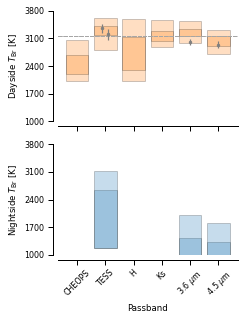

In [36]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(2, 1, figsize=(AAOCW, 1.3*AAOCW), sharey='all', sharex='all')
    ax = axs[0]
    for i, fln in enumerate(filter_names):
        cols = [c for c in tbr_day.columns if fln in c]
        d = tbr_day[cols]
        pc = percentile(d.values.ravel(), [50, 16, 84, 2.5, 97.5, 0.15, 99.85])
        ax.bar(i, pc[6]-pc[5], bottom=pc[5], fc='C01', alpha=0.25, width=0.8, ec='k')
        ax.bar(i, pc[2]-pc[1], bottom=pc[1], fc='C01', alpha=0.25, width=0.8, ec='k')
        ax.axhline(rr.x, lw=1, ls='--', c='0.65')
    
    ax.errorbar(0.9, 3350, 115, fmt='.', c='0.5')  # Beatty et al. (2020)
    ax.errorbar(1.1, 3201, 147, fmt='.', c='0.5')  # Von Essen et al. (2020)
    ax.errorbar(  4, 3013,  72, fmt='.', c='0.5')  # Beatty et al. (2019)
    ax.errorbar(  5, 2941,  84, fmt='.', c='0.5')  # Beatty et al. (2019)

    ax = axs[1]
    for i in (1,4,5):
        fln = filter_names[i]
        cols = [c for c in tbr_night.columns if fln in c]
        d = tbr_night[cols]
        pc = percentile(d.values.ravel(), [0.0, 90, 99])
        for j in range(2):
            ax.bar(i, pc[j+1]-pc[0], bottom=pc[0], fc='C0', alpha=0.25, width=0.8, ec='k')

    
    setp(axs[0], ylabel='Dayside $T_\mathrm{Br}$ [K]')
    setp(axs[1], xlabel='Passband', xticks=arange(6), 
         yticks=linspace(1000, 3800, 5), ylim=(999, 3800), ylabel='Nightside $T_\mathrm{Br}$ [K]')
    sb.despine(offset=5)
    ax.set_xticklabels(r'CHEOPS, TESS, H, Ks, 3.6 $\mu$m,  4.5 $\mu$m'.split(', '), rotation=45)
    fig.tight_layout()
    fig.savefig('plots/brightness_temperatures.pdf')

The CHEOPS and TESS bands disagree with each other, but the TESS band brightness temperature alone deviates from the best-fitting constant temperature only marginally. 

Next, lets also plot the posteriors for the separate approaches to see if the results are sensitive to the chosen approachs.

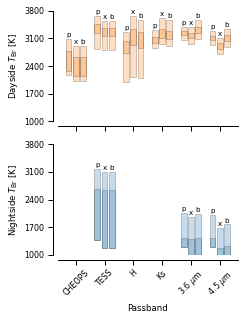

In [37]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(2, 1, figsize=(AAOCW, 1.3*AAOCW), sharey='all', sharex='all')
    ax = axs[0]
    for k, tp in enumerate('pp bp bb'.split()):
        for i, fln in enumerate(filter_names):
            pc = percentile(tbr_day[f"tbr_{tp}_{fln}"], [50, 16, 84, 2.5, 97.5, 0.15, 99.85])
            ax.text(i+0.25*(k-1), pc[-1]+50, 'pxb'[k], ha='center', size='small')
            ax.bar(i+0.25*(k-1), pc[6]-pc[5], bottom=pc[5], fc='C01', alpha=0.25, width=0.2, ec='k')
            ax.bar(i+0.25*(k-1), pc[2]-pc[1], bottom=pc[1], fc='C01', alpha=0.25, width=0.2, ec='k')
    
    ax = axs[1]
    for k, tp in enumerate('pp bp bb'.split()):
        for i in (1,4,5):
            fln = filter_names[i]
            pc = percentile(tbr_night[f"tbr_{tp}_{fln}"], [0, 90, 99])
            ax.text(i+0.25*(k-1), pc[-1]+50, 'pxb'[k], ha='center', size='small')
            for j in range(2):
                ax.bar(i+0.25*(k-1), pc[j+1]-pc[0], bottom=pc[0], fc='C00', alpha=0.25, width=0.2, ec='k')
    
    setp(axs[0], ylabel='Dayside $T_\mathrm{Br}$ [K]')
    setp(axs[1], xlabel='Passband', xticks=arange(6), 
         yticks=linspace(1000, 3800, 5), ylim=(999, 3800), ylabel='Nightside $T_\mathrm{Br}$ [K]')
    sb.despine(offset=5)
    ax.set_xticklabels(r'CHEOPS, TESS, H, Ks, 3.6 $\mu$m,  4.5 $\mu$m'.split(', '), rotation=45)
    fig.tight_layout()
    fig.savefig('plots/brightness_temperatures_sep.pdf')

Doesn't look like that'd be the case, so everything's good here.

---

<center>&copy;2022 Hannu Parviainen</center>